# KdV Equation with Homogeneous Projection

This notebook demonstrates the use of `homproj.adaptive.solve_ivp` for simulating the Korteweg-de Vries (KdV) equation while preserving multiple conserved quantities.

The KdV equation is:
$$u_t + 6uu_x + u_{xxx} = 0$$

We use a semidiscrete spatial discretization with periodic boundary conditions, which preserves several discrete analogs of the continuous invariants.

In [127]:
%load_ext autoreload
%autoreload 2


import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

import importlib
import homproj.adaptive as adaptive
importlib.reload(adaptive)

# Import KdV utilities
from kdvutils import KdVDiscretization, soliton


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup: Semidiscrete KdV System

We discretize the spatial domain $[0, L]$ with $N$ points. We can choose between two spatial discretization methods:
- **Spectral method**: Uses FFT-based derivatives with dealiasing (3/2 padding rule)
- **Finite difference method**: Uses high-order centered differences (2nd, 4th, 6th, or 8th order accuracy)

Both methods preserve the structure of the continuous invariants in discrete form with periodic boundary conditions.


In [128]:
# Spatial discretization parameters
N = 64  # Number of spatial points
L = 40.0  # Domain length

# Choose discretization method: 'spectral' or 'fd' (finite difference)
method = 'fd'  # Try 'fd' for finite differences
fd_accuracy = 8  # Only used if method='fd' (options: 2, 4, 6, 8)

# Create KdV discretization object
kdv = KdVDiscretization(N=N, L=L, method=method, fd_accuracy=fd_accuracy)
invariants = kdv.get_invariants()
gradients = kdv.get_invariant_gradients()

# Access grid and parameters
x = kdv.x
dx = kdv.dx

print(f"Spatial grid: N={N} points, dx={dx:.4f}, L={L}")
print(f"Discretization method: {method}")
if method == 'fd':
    print(f"Finite difference accuracy: {fd_accuracy}th order")
print(f"Using analytical gradients: {len(gradients)} gradient functions")

Spatial grid: N=64 points, dx=0.6250, L=40.0
Discretization method: fd
Finite difference accuracy: 8th order
Using analytical gradients: 3 gradient functions


## Initial Condition: Single Soliton Solution

The exact soliton solution for the KdV equation is:
$$u(x,t) = \frac{c}{2}\operatorname{sech}^2\left(\frac{\sqrt{c}}{2}(x - ct - x_0)\right)$$

This will allow us to compare numerical solutions against the analytical solution.

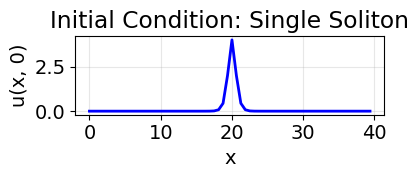

Values of u0 at boundaries: 8.664512317763965e-24 2.6116884394870616e-23


In [129]:
# Create single soliton initial condition
c1 = 8  # Soliton speed
x01 = 20.0  # Initial position (matching kdv.ipynb)

u0 = soliton(x, c1, x01, L=L, plot=True) 
print("Values of u0 at boundaries:", u0[0], u0[-1])

In [130]:
# Check how well the semidiscretization preserves each invariant
conservation_errors = kdv.check_conservation(u0)

print("Semidiscretization conservation check (∇I · f):")
print(f"  Mass: {conservation_errors['mass']:.3e}")
print(f"  Momentum: {conservation_errors['momentum']:.3e}")
print(f"  Energy: {conservation_errors['energy']:.3e}")


Semidiscretization conservation check (∇I · f):
  Mass: 1.138e-14
  Momentum: 3.585e-14
  Energy: 8.522e-14


## Solve with Homogeneous Projection

Now we'll integrate the KdV equation using `adaptive.solve_ivp` with the homogeneous projector to preserve all three invariants. We compare against a standard adaptive solver without projection.

**Performance optimization**: We provide analytical gradient functions (`gradients=gradients`) to avoid expensive numerical finite differences. This provides a significant speedup (~50-100x faster projection) compared to numerical Jacobian computation.

In [131]:
# Time span for integration (long time to see multiple periods)
from time import time

t_span = (0, 100)

low_tol = 1e-5
high_tol = 1e-5

print("Solving with HomogeneousProjector preserving all 3 invariants (with analytical gradients)...")
t0 = time()
sol_projected = adaptive.solve_ivp(
    kdv.kdv_rhs,  # Use the RHS from the discretization object
    t_span, 
    u0,
    method='DOP853',
    invariants=invariants,
    gradients=gradients,  # Use analytical gradients for speed!
    max_iterations=1,
    integrator='rk1',
    itol=1e-12,
    rtol=high_tol,
    atol=high_tol,
    mode='alternating',
)
print(f"Solved in {time() - t0:.2f} seconds.")
print(f"  Status: {sol_projected.message}")
print(f"  Function evaluations: {sol_projected.nfev}")
print(f"  Time points: {len(sol_projected.t)}")

# Solve with projection preserving only mass and energy (not momentum)
print("\nSolving with HomogeneousProjector preserving mass and energy only...")
kdv.dealias = False
t0 = time()
sol_projected_2inv = adaptive.solve_ivp(
    kdv.kdv_rhs,
    t_span, 
    u0,
    method='DOP853',
    invariants=[invariants[0], invariants[2]],  # Mass and energy only (skip momentum)
    gradients=[gradients[0], gradients[2]],      # Corresponding gradients
    max_iterations=1,
    integrator='rk1',
    itol=1e-12,
    rtol=high_tol,
    atol=high_tol,
    mode='alternating',
)
print(f"Solved in {time() - t0:.2f} seconds.")
print(f"  Status: {sol_projected_2inv.message}")
print(f"  Function evaluations: {sol_projected_2inv.nfev}")
print(f"  Time points: {len(sol_projected_2inv.t)}")

# Solve without projection for comparison
print("\nSolving without projection (standard DOP853)...")
t0 = time()
import scipy

sol_standard = scipy.integrate.solve_ivp(
    kdv.kdv_rhs,  # Use the same RHS
    t_span,
    u0,
    method='DOP853',
    rtol=low_tol,
    atol=low_tol
)

print(f"Solved in {time() - t0:.2f} seconds.")
print(f"  Status: {sol_standard.message}")
print(f"  Function evaluations: {sol_standard.nfev}")
print(f"  Time points: {len(sol_standard.t)}")

Solving with HomogeneousProjector preserving all 3 invariants (with analytical gradients)...
Solved in 144.91 seconds.
  Status: The solver successfully reached the end of the integration interval.
  Function evaluations: 327062
  Time points: 14359

Solving with HomogeneousProjector preserving mass and energy only...
Solved in 4.64 seconds.
  Status: Required step size is less than spacing between numbers.
  Function evaluations: 10250
  Time points: 505

Solving without projection (standard DOP853)...
Solved in 3.05 seconds.
  Status: Required step size is less than spacing between numbers.
  Function evaluations: 7118
  Time points: 456


## Verify Invariant Preservation

Compute the invariants at each time step and check how well they are preserved.

In [132]:
# Compute invariants along the solution trajectories
def compute_invariants_trajectory(sol):
    """Compute all three invariants at each time point."""
    I1 = np.zeros(len(sol.t))
    I2 = np.zeros(len(sol.t))
    I3 = np.zeros(len(sol.t))
    
    for i, u in enumerate(sol.y.T):
        inv = kdv.compute_invariants(u)
        I1[i] = inv['mass']
        I2[i] = inv['momentum']
        I3[i] = inv['energy']
    
    return I1, I2, I3

# Compute for all three solutions
I1_proj, I2_proj, I3_proj = compute_invariants_trajectory(sol_projected)
I1_proj2, I2_proj2, I3_proj2 = compute_invariants_trajectory(sol_projected_2inv)
I1_std, I2_std, I3_std = compute_invariants_trajectory(sol_standard)

# Get initial values
initial_invariants = kdv.compute_invariants(u0)
I1_0 = initial_invariants['mass']
I2_0 = initial_invariants['momentum']
I3_0 = initial_invariants['energy']

# Compute relative errors
def relative_error(values, initial):
    return np.abs(values - initial) / np.abs(initial)

I1_err_proj = relative_error(I1_proj, I1_0)
I2_err_proj = relative_error(I2_proj, I2_0)
I3_err_proj = relative_error(I3_proj, I3_0)

I1_err_proj2 = relative_error(I1_proj2, I1_0)
I2_err_proj2 = relative_error(I2_proj2, I2_0)
I3_err_proj2 = relative_error(I3_proj2, I3_0)

I1_err_std = relative_error(I1_std, I1_0)
I2_err_std = relative_error(I2_std, I2_0)
I3_err_std = relative_error(I3_std, I3_0)

## Plot Invariant Evolution

Visualize how well the invariants are preserved over time.

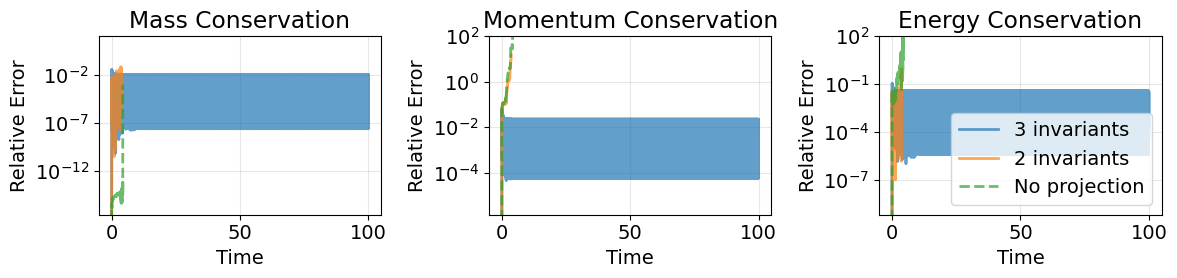

In [133]:
# Compute L2 error vs exact solution over time
l2_proj = []
l2_proj2 = []
l2_std = []

for i, t in enumerate(sol_projected.t):
    u_exact = soliton(x, c1, x01, t, L=L)
    u_proj = sol_projected.y[:, i]
    l2_proj.append(np.sqrt(dx * np.sum((u_proj - u_exact)**2)))

for i, t in enumerate(sol_projected_2inv.t):
    u_exact = soliton(x, c1, x01, t, L=L)
    u_proj2 = sol_projected_2inv.y[:, i]
    l2_proj2.append(np.sqrt(dx * np.sum((u_proj2 - u_exact)**2)))

for i, t in enumerate(sol_standard.t):
    u_exact = soliton(x, c1, x01, t, L=L)
    u_std = sol_standard.y[:, i]
    l2_std.append(np.sqrt(dx * np.sum((u_std - u_exact)**2)))

# Set font size larger
plt.rcParams['font.size'] = 14

# Create 3-panel plot
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# Plot I₁ (mass)
axes[0].semilogy(sol_projected.t, I1_err_proj, '-', linewidth=2, label='3 invariants', alpha=0.7)
axes[0].semilogy(sol_projected_2inv.t, I1_err_proj2, '-', linewidth=2, label='2 invariants (I₁, I₃)', alpha=0.7)
axes[0].semilogy(sol_standard.t, I1_err_std, '--', linewidth=2, label='Without projection', alpha=0.7)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Relative Error')
axes[0].set_ylim([None, 1e2])
axes[0].set_title('Mass Conservation')
# axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot I₂ (momentum)
axes[1].semilogy(sol_projected.t, I2_err_proj, '-', linewidth=2, label='3 invariants', alpha=0.7)
axes[1].semilogy(sol_projected_2inv.t, I2_err_proj2, '-', linewidth=2, label='2 invariants (I₁, I₃)', alpha=0.7)
axes[1].semilogy(sol_standard.t, I2_err_std, '--', linewidth=2, label='Without projection', alpha=0.7)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Relative Error')
axes[1].set_ylim([None, 1e2])
axes[1].set_title('Momentum Conservation')
# axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot I₃ (energy)
axes[2].semilogy(sol_projected.t, I3_err_proj, '-', linewidth=2, label='3 invariants', alpha=0.7)
axes[2].semilogy(sol_projected_2inv.t, I3_err_proj2, '-', linewidth=2, label='2 invariants', alpha=0.7)
axes[2].semilogy(sol_standard.t, I3_err_std, '--', linewidth=2, label='No projection', alpha=0.7)
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Relative Error')
axes[2].set_ylim([None, 1e2])
axes[2].set_title('Energy Conservation')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig.savefig(f'kdv_errors_N={N}_c={c1}_{method}_T={t_span[-1]}.png', dpi=150, bbox_inches='tight')


## Visualize Solution Evolution

Plot the solution at different times to see the soliton interaction.

[  0.  25.  50.  75. 100.]
The numerical solutions closely track the exact soliton solution.


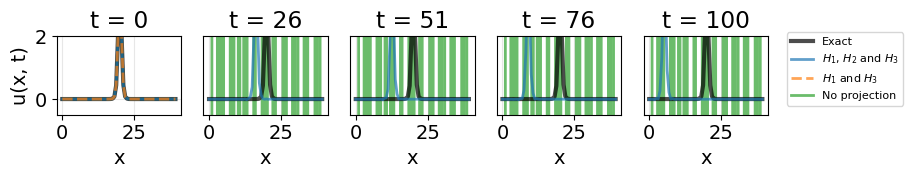

In [134]:
# Plot solution at selected times, comparing with exact solution
from numpy import ceil


n_plots = 5
fig, axes = plt.subplots(1, n_plots, figsize=(8, 2))
axes = axes.flatten()

# Find indices closest to desired times
times_to_plot = np.linspace(0, t_span[-1], n_plots)

print(times_to_plot)

for idx, t_plot in enumerate(times_to_plot):
    # Find closest time point in solutions
    idx_proj = np.argmin(np.abs(sol_projected.t - t_plot))
    idx_proj2 = np.argmin(np.abs(sol_projected_2inv.t - t_plot))
    idx_std = np.argmin(np.abs(sol_standard.t - t_plot))
    
    u_proj = sol_projected.y[:, idx_proj]
    u_proj2 = sol_projected_2inv.y[:, idx_proj2]
    u_std = sol_standard.y[:, idx_std]
    t_actual = sol_projected.t[idx_proj]
    
    # Compute exact solution at this time
    u_exact = soliton(x, c1, x01, t_actual, L=L)
    
    # Plot exact solution first (in black)
    axes[idx].plot(x, u_exact, 'k-', linewidth=3, label='Exact', alpha=0.7)
    axes[idx].plot(x, u_proj, linewidth=2, label=f'$H_1$, $H_2$ and $H_3$', alpha=0.7)
    axes[idx].plot(x, u_proj2, linewidth=2, label=f'$H_1$ and $H_3$', linestyle='--', alpha=0.7)
    axes[idx].plot(x, u_std, alpha=0.7, linewidth=2, label=f'No projection', zorder=1)
    axes[idx].set_xlabel('x')
    axes[idx].set_ylabel('u(x, t)') if idx == 0 else axes[idx].set_ylabel('')
    axes[idx].set_title(f't = {int(ceil(t_actual))}')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_yticks([]) if idx != 0 else None
    axes[idx].set_ylim([-0.5, 2.0])

# Place legend outside the figure to the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.6), fontsize=8)

# Save figure with tolerances in filename
plt.tight_layout()
plt.savefig(f'kdv_solutions_N={N}_c={c1}_{method}_T={t_span[-1]}.png', dpi=150, bbox_inches='tight')
print("The numerical solutions closely track the exact soliton solution.")

## Space-Time Visualization

Create a contour plot showing the full solution evolution.

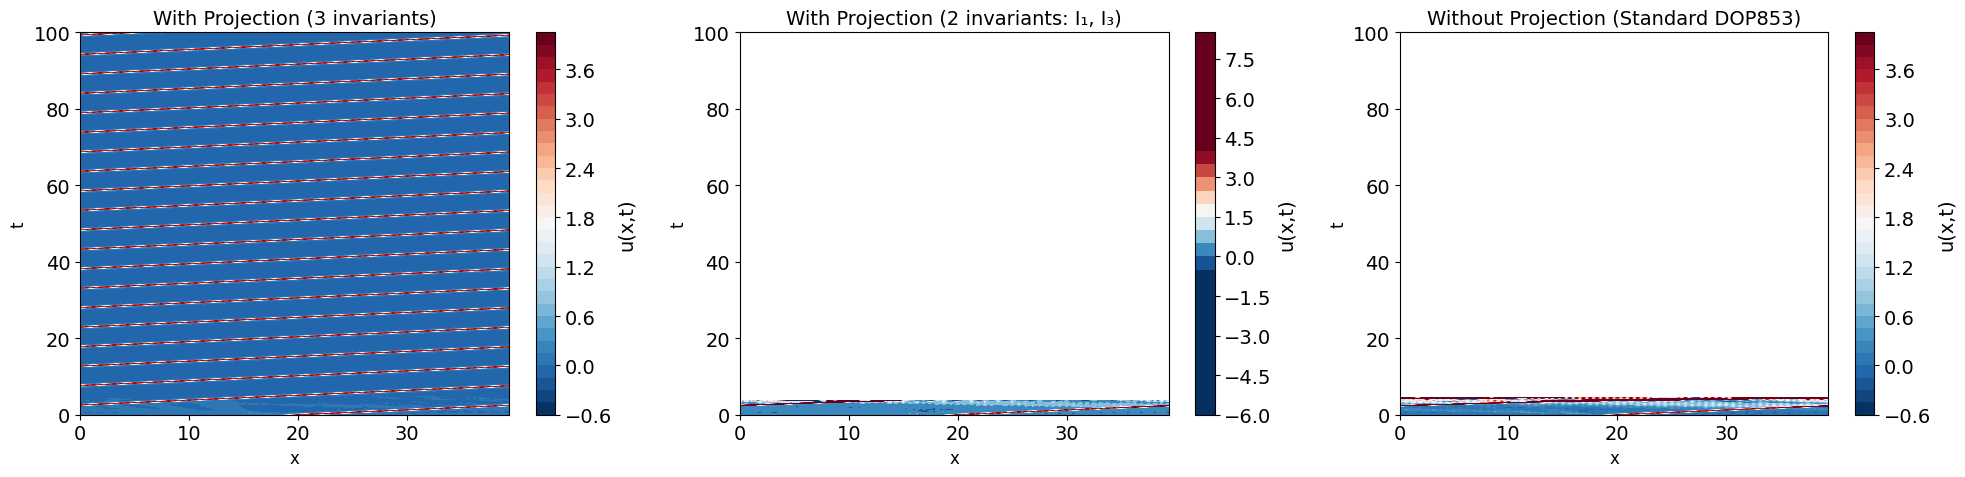

The space-time plots show the soliton propagation with periodic boundaries.
All plots use the same color scale for direct comparison.


In [135]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Determine color limits from projected solution
vmin = np.min(sol_projected.y)
vmax = np.max(sol_projected.y)

# Plot with projection (3 invariants)
T_proj, X_proj = np.meshgrid(sol_projected.t, x)
contour1 = axes[0].contourf(X_proj, T_proj, sol_projected.y, levels=30, cmap='RdBu_r', 
                        vmin=vmin, vmax=vmax)
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('t', fontsize=12)
axes[0].set_title('With Projection (3 invariants)', fontsize=14)
axes[0].set_ylim([0, t_span[1]])
plt.colorbar(contour1, ax=axes[0], label='u(x,t)')

# Plot with projection (2 invariants)
T_proj2, X_proj2 = np.meshgrid(sol_projected_2inv.t, x)
contour2 = axes[1].contourf(X_proj2, T_proj2, sol_projected_2inv.y, levels=30, cmap='RdBu_r', 
                        vmin=vmin, vmax=vmax)
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('t', fontsize=12)
axes[1].set_title('With Projection (2 invariants: I₁, I₃)', fontsize=14)
axes[1].set_ylim([0, t_span[1]])
plt.colorbar(contour2, ax=axes[1], label='u(x,t)')

# Plot without projection (with same color limits and full time range)
T_std, X_std = np.meshgrid(sol_standard.t, x)
# Clip values to the same range as projected solution
sol_standard_clipped = np.clip(sol_standard.y, vmin, vmax)
contour3 = axes[2].contourf(X_std, T_std, sol_standard_clipped, levels=30, cmap='RdBu_r',
                        vmin=vmin, vmax=vmax)
axes[2].set_xlabel('x', fontsize=12)
axes[2].set_ylabel('t', fontsize=12)
axes[2].set_title('Without Projection (Standard DOP853)', fontsize=14)
axes[2].set_ylim([0, t_span[1]])
plt.colorbar(contour3, ax=axes[2], label='u(x,t)')

plt.tight_layout()
plt.show()

print("The space-time plots show the soliton propagation with periodic boundaries."
      "\nAll plots use the same color scale for direct comparison.")

## Summary

This notebook demonstrated:

1. **Semidiscrete KdV system**: Used spectral methods for spatial derivatives, preserving the structure of continuous conservation laws
2. **Multiple invariants**: Defined three conserved quantities (mass, momentum, energy) as callable functions
3. **Selective invariant preservation**: Compared two projection strategies:
   - Preserving all 3 invariants (mass, momentum, energy)
   - Preserving only 2 invariants (mass and energy, allowing momentum to drift)
4. **Analytical gradients**: Provided gradient functions for fast projection (avoiding expensive numerical Jacobian)
5. **Invariant preservation**: The projection methods kept their respective invariants at machine precision
6. **Solution quality**: All methods produced visually similar solutions, with the projected methods exactly preserving their chosen conservation laws

Key observations:
- The 3-invariant method preserves all conservation laws simultaneously
- The 2-invariant method (I₁, I₃) shows that momentum (I₂) drifts while mass and energy remain conserved
- Both projection methods maintain better long-term accuracy than standard integration

The `adaptive.solve_ivp` interface allows flexible selection of which invariants to preserve, requiring only:
- The dynamics function `fun(t, y)`
- A list of invariant functions (choose which ones to preserve!)
- Optional analytical gradients for performance
- Standard scipy tolerances and method selection